In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.signal import savgol_filter
import statsmodels.api as sm
from scipy import fftpack


In [2]:
func_list =[]
def list_docorator(func):
    func_list.append(func)
    return func

In [3]:
size = 1000
x = np.linspace(0, 4 * np.pi, size)
y1=np.sin(x)+0.1
y = np.sin(x) + np.random.random(size) * 0.2
data = {"x": x, "y": y}


In [4]:
def test_func(f, label,ax):  # f: function handle to one of the smoothing methods
    start = time()
    for i in range(5):
        arr = f(data["y"], 20)
    print(f"{label:26s} - time: {time() - start:8.5f} ")
    ax.plot(data["x"], arr, "-", label=label)

In [5]:
@list_docorator
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span*2 + 1) / (span*2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that
    # reaches beyond the data, keeps the other side the same size as given
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re


@list_docorator
def smooth_data_np_average(arr, span):     # my original, naive approach
    return [
        np.average(arr[val - span:val + span + 1]) for val in range(len(arr))
        ]


@list_docorator
def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span*2 + 1) / (span*2 + 1), mode="same")


@list_docorator
def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2*span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))


# @list_docorator
def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(
        arr, x, frac=(5 * span / len(arr)), return_sorted=False
        )



def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]


# @list_docorator
def smooth_data_savgol_0(arr, span):
    return savgol_filter(arr, span*2 + 1, 0)


# @list_docorator
def smooth_data_savgol_1(arr, span):
    return savgol_filter(arr, span*2 + 1, 1)


# @list_docorator
def smooth_data_savgol_2(arr, span):
    return savgol_filter(arr, span*2 + 1, 2)


# @list_docorator
def smooth_data_fft(
        arr, span
    ):     # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w**2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

smooth_data_convolve_my_average - time:  0.00200 
smooth_data_np_average     - time:  0.05000 
smooth_data_np_convolve    - time:  0.00000 
smooth_data_np_cumsum_my_average - time:  0.00100 


c:\Python38\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 1.1)

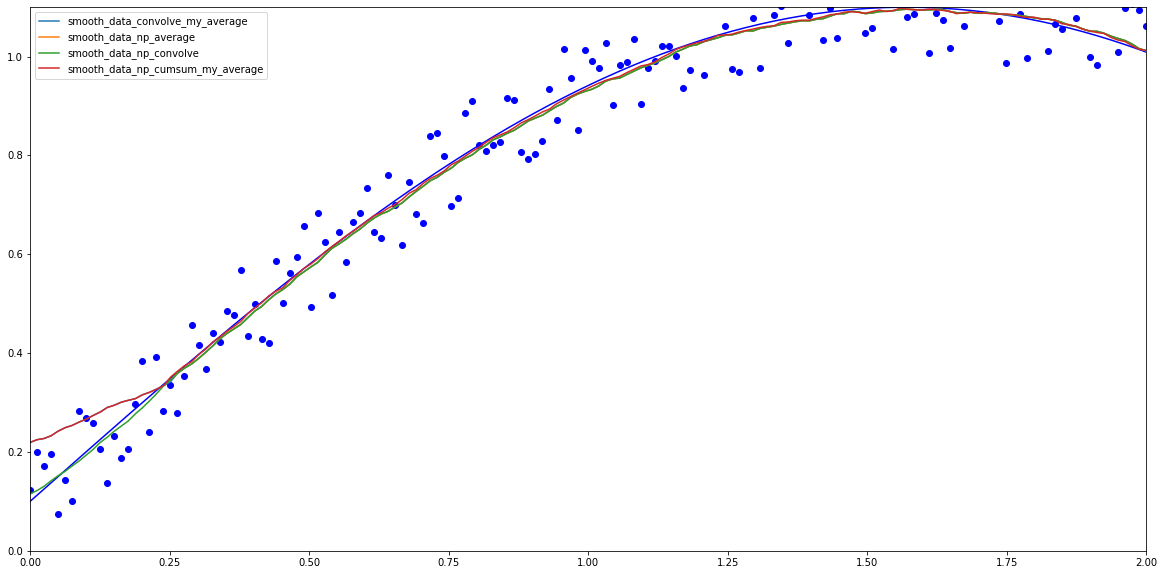

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.plot(x,y,'bo')
ax.plot(x,y1,'b-')
for func in func_list:
    test_func(func,func.__name__,ax)

ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(0,1.1)